In [207]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

K=10000

In [55]:
dfs = []
for i in range(1, 4):
    df = pd.read_csv(f"../../data2024/island-data-bottle-round-4/prices_round_4_day_{i}.csv", sep=";")
    dfs.append(df)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df.head()


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,COCONUT,9999.0,200.0,NaN,NaN,NaN,NaN,10001,200,NaN,NaN,NaN,NaN,10000.0,0.0
1,1,0,COCONUT_COUPON,637.0,39.0,NaN,NaN,NaN,NaN,638,39,NaN,NaN,NaN,NaN,637.5,0.0
2,1,100,COCONUT,9999.0,104.0,9998.0,44.0,NaN,NaN,10000,104,10001.0,44.0,NaN,NaN,9999.5,0.0
3,1,100,COCONUT_COUPON,637.0,33.0,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,637.5,0.0
4,1,200,COCONUT,9998.0,133.0,9997.0,62.0,NaN,NaN,9999,133,10000.0,62.0,NaN,NaN,9998.5,0.0


In [58]:
df["T"] = np.arange(0, len(df))/len(df)
coupons = df[df["product"] == "COCONUT_COUPON"]
coupons.index = np.arange(0, len(coupons))*100
prices = df[df["product"] == "COCONUT"]
prices.index = np.arange(0, len(prices))*100

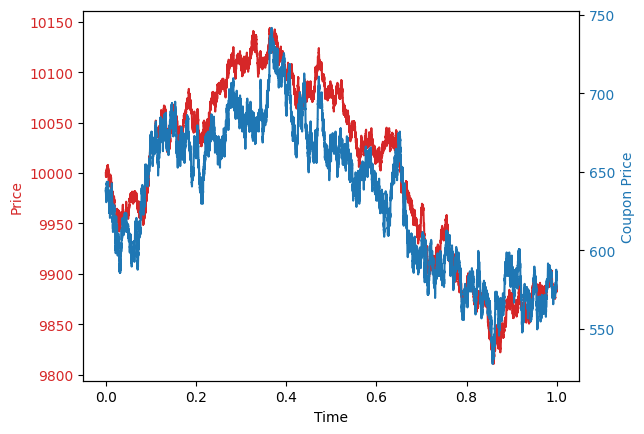

In [59]:
# create plot with two y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(prices["T"], prices["mid_price"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Coupon Price', color=color)
ax2.plot(coupons["T"], coupons["mid_price"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [158]:
vol = prices.mid_price.pct_change().std()*np.sqrt(len(prices)) / np.sqrt(3)
K = 10_000
vol

0.010293960957374844

<Axes: >

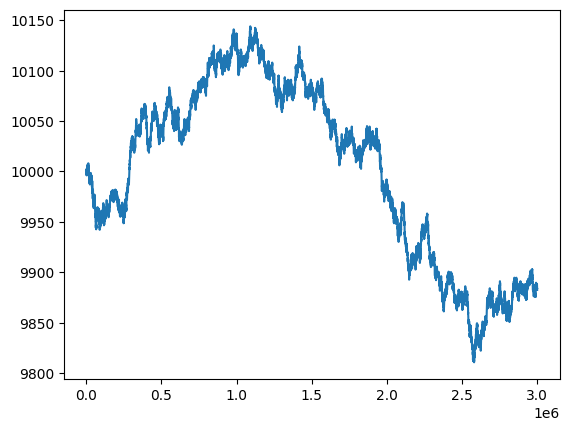

In [159]:
prices.mid_price.plot()

In [178]:
def black_scholes_call(S, K, vol, T, r):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [179]:
coupons_theo = black_scholes_call(prices.mid_price, K, vol, 250 - np.linspace(0, 3, len(prices)), 0.0)

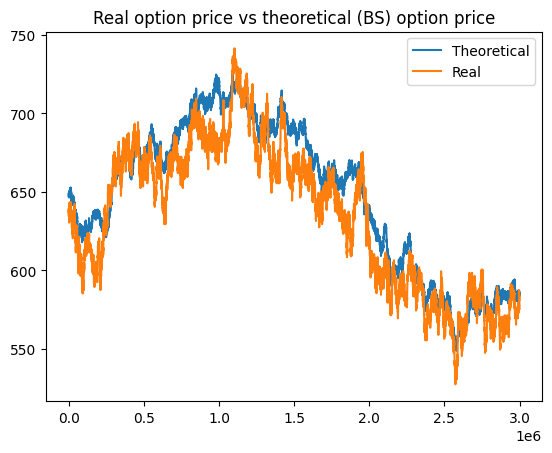

In [181]:

plt.plot(coupons_theo, label="Theoretical")
plt.plot(coupons.mid_price, label="Real")
plt.title("Real option price vs theoretical (BS) option price")
plt.legend();

In [182]:
def vol_from_black_scholes_call(S, K, T, r, call):
    def f(vol):
        return black_scholes_call(S, K, vol, T, r)[0] - call
    return f

In [183]:
from scipy.optimize import fsolve

In [184]:
vols = []
for i, row in coupons.iterrows():
    vol = fsolve(vol_from_black_scholes_call(prices.mid_price[i], K, 250 - prices["T"][i], 0.0, row.mid_price), 0.02)
    vols.append(vol[0])
vols = pd.Series(vols)

C:\Users\giova\AppData\Local\Temp\ipykernel_29148\3792116204.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  vol = fsolve(vol_from_black_scholes_call(prices.mid_price[i], K, 250 - prices["T"][i], 0.0, row.mid_price), 0.02)


In [258]:
def standard_normal_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def _bsm_call(S, K, T, r, sigma):
    piece_1 = np.log(S / K)
    piece_2 = (r + 0.5 * (sigma ** 2)) * T
    print(piece_2)
    d1 = (piece_1 +  piece_2)/(sigma * np.sqrt(T))
    print(d1)
    d2 = d1 - sigma * np.sqrt(T)
    cdf_d1 = standard_normal_cdf(d1)
    cdf_d2 = standard_normal_cdf(d2)

    print(d1, d2)

    return S*cdf_d1 - K*np.exp(-r*T)*cdf_d2

def _compute_implied_vol(coco_price: float, coupon_price: float) -> float:
    def f(sigma):
        bs_call = _bsm_call(coco_price, 10_000, 246, 0, sigma)

        return bs_call - coupon_price

    tol = 1e-6 
    max_iter = 100
    low = 0
    high = 1

    for _ in range(max_iter):
        mid = (low + high) / 2
        if f(mid) > 0:
            high = mid
        else:
            low = mid
        
        if abs(high - low) < tol:
            return mid

In [260]:
prices.iloc[20000:]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,T
2000000,3,0,COCONUT,9990.0,148.0,9989.0,61.0,NaN,NaN,9992,209,NaN,NaN,NaN,NaN,9991.0,0.0,0.666667
2000100,3,100,COCONUT,9989.0,171.0,NaN,NaN,NaN,NaN,9991,114,9992.0,57.0,NaN,NaN,9990.0,0.0,0.666700
2000200,3,200,COCONUT,9990.0,135.0,9989.0,57.0,NaN,NaN,9991,135,9992.0,57.0,NaN,NaN,9990.5,0.0,0.666733
2000300,3,300,COCONUT,9991.0,138.0,9990.0,43.0,NaN,NaN,9992,138,9993.0,43.0,NaN,NaN,9991.5,0.0,0.666783
2000400,3,400,COCONUT,9989.0,128.0,9988.0,44.0,NaN,NaN,9991,172,NaN,NaN,NaN,NaN,9990.0,0.0,0.666800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999500,3,999500,COCONUT,9883.0,141.0,9882.0,66.0,NaN,NaN,9884,141,9885.0,66.0,NaN,NaN,9883.5,0.0,0.999850
2999600,3,999600,COCONUT,9884.0,119.0,9883.0,75.0,NaN,NaN,9885,119,9886.0,75.0,NaN,NaN,9884.5,0.0,0.999883
2999700,3,999700,COCONUT,9883.0,115.0,9882.0,53.0,NaN,NaN,9884,115,9885.0,53.0,NaN,NaN,9883.5,0.0,0.999900
2999800,3,999800,COCONUT,9883.0,127.0,9882.0,46.0,NaN,NaN,9885,164,NaN,NaN,NaN,NaN,9884.0,0.0,0.999950


In [196]:
vols.std()

0.00021455736370659862

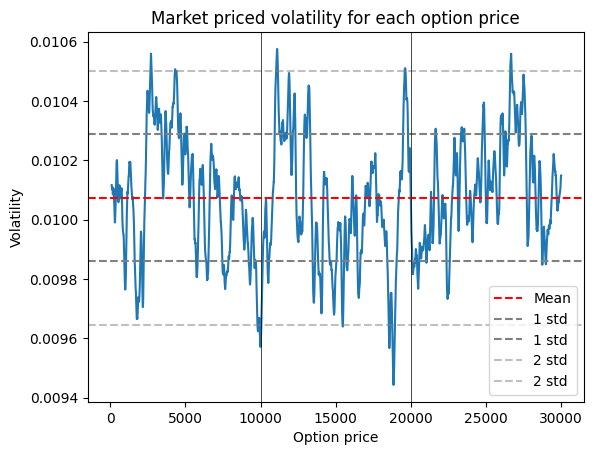

In [192]:
plt.plot(pd.Series(vols).rolling(100).mean())
plt.axline((0, np.mean(vols)), slope=0, color="red", linestyle="--", label="Mean")
plt.axline((0, np.mean(vols) + np.std(vols)), slope=0, color="grey", linestyle="--", label="1 std")
plt.axline((0, np.mean(vols) - np.std(vols)), slope=0, color="grey", linestyle="--", label="1 std")
plt.axline((0, np.mean(vols) + 2*np.std(vols)), slope=0, color="grey", linestyle="--", alpha=0.5, label="2 std")
plt.axline((0, np.mean(vols) - 2*np.std(vols)), slope=0, color="grey", linestyle="--", alpha=0.5, label="2 std")
plt.axvline(len(vols)//3, color="black", linewidth=0.5)
plt.axvline(2*len(vols)//3, color="black", linewidth=0.5)
plt.title("Volatility for each option price")
plt.title("Market priced volatility for each option price")
plt.ylabel("Volatility")
plt.xlabel("Option price")
plt.legend();

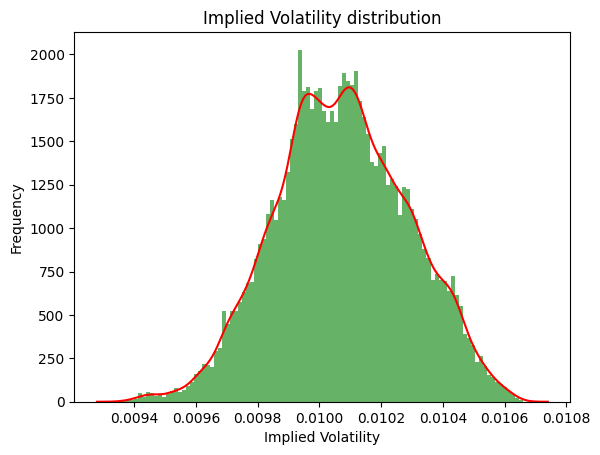

In [193]:
import seaborn as sns
plt.hist(vols, bins=100, density=True, alpha=0.6, color='g')
sns.kdeplot(vols, color="red")
plt.title("Implied Volatility distribution")
plt.xlabel("Implied Volatility")
plt.ylabel("Frequency");

In [194]:
display(pd.DataFrame({
    "mean": vols.mean(),
    "std": vols.std(),
    "skew": vols.skew(),
    "kurtosis": vols.kurtosis()
}, index=["implied volatility"]))

# give normal skew and kurt for comparison
display(pd.DataFrame({
    "mean": vols.mean(),
    "std": vols.std(),
    "skew": 0,
    "kurtosis": 3
}, index=["normal volatility"]))

,mean,std,skew,kurtosis
implied volatility,0.010074,0.000215,-0.015985,-0.298132


,mean,std,skew,kurtosis
normal volatility,0.010074,0.000215,0,3


Kurtosis is suspiciously small, which means that the tails of the distribution are not heavy enough. This is a hint that the distribution is not normal.

In [195]:
def black_scholes_delta(S, K, vol, T, r):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return norm.cdf(d1)

In [42]:
deltas = []
for _, row in prices.iterrows():
    deltas.append(black_scholes_delta(row.mid_price, K, vol, 250/3 - row["T"], 0.0)[0])

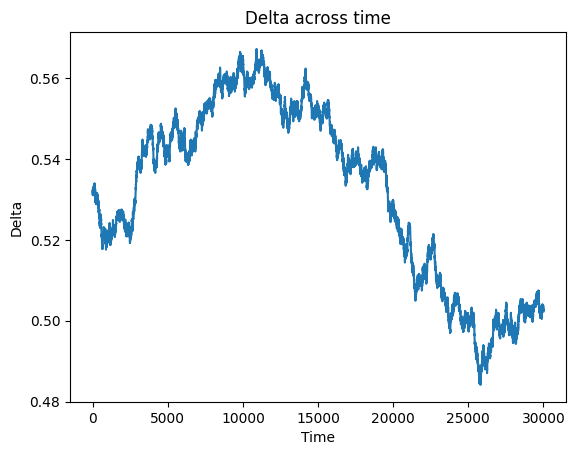

In [43]:
plt.plot(deltas)
plt.title("Delta across time")
plt.ylabel("Delta")
plt.xlabel("Time");

Let $V_t$ denote the portfolio at time $t$

we know that,the delta hedge portfolio is given by

$V_t = \pm(\Delta_t S_t - C_t)$

where $\Delta_t$ is the number of shares of the stock to hold at time $t$ and $C_t$ is the value of the option at time $t$

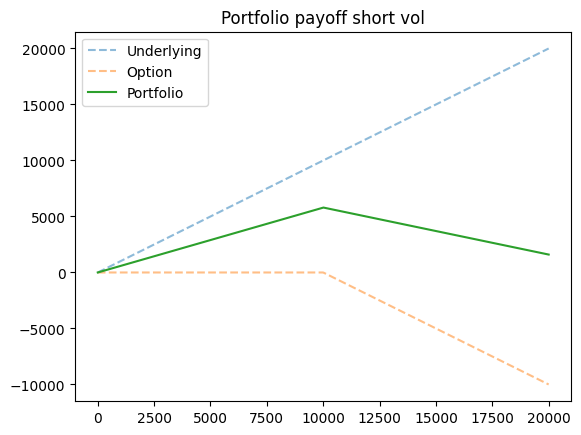

In [44]:
payoff_underlying = lambda x: x
payoff_option = lambda x: np.where(x > K, x - K, 0)

x = np.linspace(0, 2*K, 1000)
delta = 0.58
plt.plot(x, payoff_underlying(x), label="Underlying", linestyle="--", alpha=0.5)
plt.plot(x, -payoff_option(x), label="Option", linestyle="--", alpha=0.5)
plt.plot(x, delta*payoff_underlying(x) - payoff_option(x), label="Portfolio")
plt.title("Portfolio payoff short vol")
plt.legend();

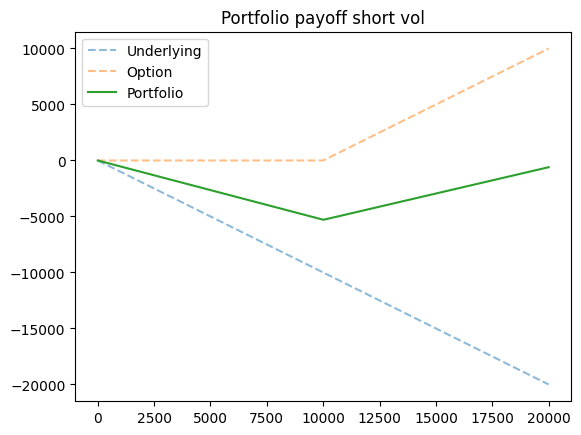

In [45]:
x = np.linspace(0, 2*K, 1000)
delta = 0.53
plt.plot(x, -payoff_underlying(x), label="Underlying", linestyle="--", alpha=0.5)
plt.plot(x, payoff_option(x), label="Option", linestyle="--", alpha=0.5)
plt.plot(x, -delta*payoff_underlying(x) + payoff_option(x), label="Portfolio")
plt.title("Portfolio payoff short vol")
plt.legend();

### Backtest

In [46]:
table = prices[["T", "timestamp", "mid_price"]].copy()
table["bid_ask_spread"] = prices["ask_price_1"] - prices["bid_price_1"]
table["market_call"] = coupons.mid_price
table["theo_call"] = coupons_theo
table["vol"] = vols
table["delta"] = deltas

In [47]:
table

,T,timestamp,mid_price,bid_ask_spread,market_call,theo_call,vol,delta
0,0.000000,0,10000.0,2.0,637.5,640.103142,0.017524,0.532005
100,0.000033,100,9999.5,1.0,637.5,639.837042,0.017458,0.531881
200,0.000067,200,9998.5,1.0,637.5,639.305157,0.017512,0.531634
300,0.000117,300,9999.5,1.0,638.5,639.836723,0.017240,0.531881
400,0.000133,400,9998.5,1.0,637.5,639.304901,0.017803,0.531634
...,...,...,...,...,...,...,...,...
2999500,0.999850,999500,9883.5,1.0,577.5,576.002949,NaN,0.502565
2999600,0.999883,999600,9884.5,1.0,577.5,576.505513,NaN,0.502818
2999700,0.999900,999700,9883.5,1.0,575.5,576.002757,NaN,0.502565
2999800,0.999950,999800,9884.0,2.0,575.5,576.253881,NaN,0.502692


In [48]:
vol_mean = table["vol"].mean()
vol_std = table["vol"].std()
deviation_to_trade = 2
table["long_short_vol"] = np.where(table["vol"] < vol_mean - deviation_to_trade*vol_std, 1, 0)
table["long_short_vol"] = np.where(table["vol"] > vol_mean + deviation_to_trade*vol_std, -1, table["long_short_vol"])
table["position"] = table["long_short_vol"].rolling(100).mean()*table["delta"]

In [49]:
table["nav"] = np.where(table["long_short_vol"] == 1, -table["position"]*(table["mid_price"].shift(-1) - table["mid_price"]) + (table["market_call"].shift(-1) - table["market_call"]) - 0.5, 0)
table["nav"] = np.where(table["long_short_vol"] == -1, table["position"]*(table["mid_price"].shift(-1) - table["mid_price"]) - (table["market_call"].shift(-1) - table["market_call"]) - 0.5, table["nav"])

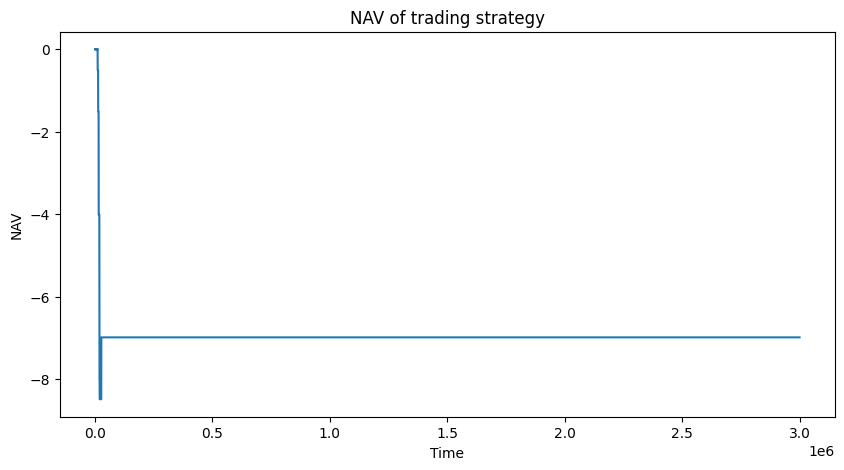

In [50]:
plt.figure(figsize=(10, 5))
table["nav"].cumsum().plot()
plt.title("NAV of trading strategy")
plt.ylabel("NAV")
plt.xlabel("Time");

In [51]:
vol_mean

0.017475095879288752